In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy 
from spacy import displacy
from spacy import tokenizer
import re
import nltk 
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import gensim 
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import LsiModel, TfidfModel
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [4]:
#set plot options 
plt.rcParams['figure.figsize'] = (10, 6)
default_plot_colour = '#00bfbf'

In [5]:
data = pd.read_csv("fake_news_data.csv")

In [6]:
data.head()

,title,text,date,fake_or_factual
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   title            198 non-null    object
 1   text             198 non-null    object
 2   date             198 non-null    object
 3   fake_or_factual  198 non-null    object
dtypes: object(4)
memory usage: 6.3+ KB


Text(0.5, 1.0, 'Distribution of Fake and Factual News')

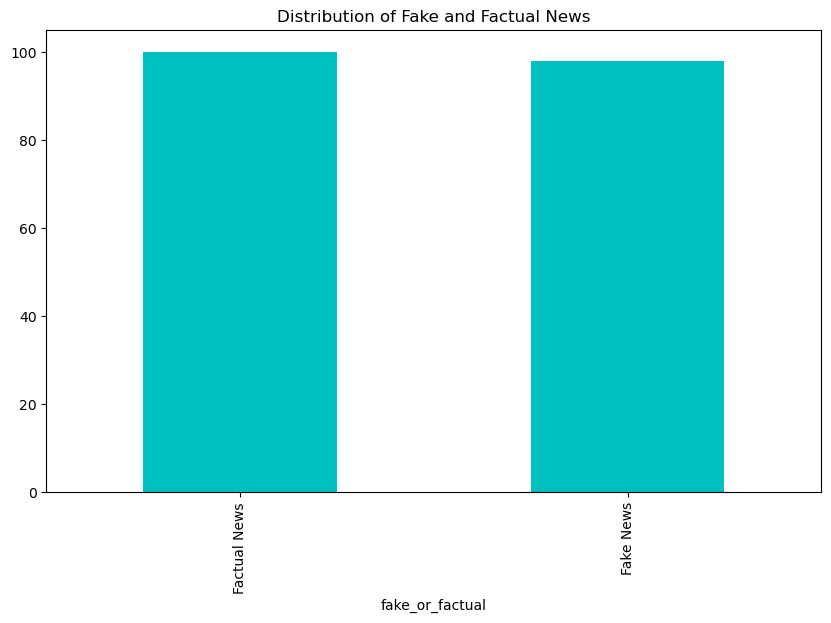

In [8]:
data['fake_or_factual'].value_counts().plot(kind='bar', color=default_plot_colour)
plt.title('Distribution of Fake and Factual News')

## POS Tags

In [16]:
!python -m spacy download en_core_web_sm
nlp = spacy.load('en_core_web_sm')

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --- ------------------------------------ 1.0/12.8 MB 10.1 MB/s eta 0:00:02
     ---- ----------------------------------- 1.6/12.8 MB 4.2 MB/s eta 0:00:03
     ------------ --------------------------- 3.9/12.8 MB 6.9 MB/s eta 0:00:02
     --------------------------- ------------ 8.7/12.8 MB 11.2 MB/s eta 0:00:01
     --------------------------------------  12.6/12.8 MB 13.6 MB/s eta 0:00:01
     --------------------------------------- 12.8/12.8 MB 12.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [17]:
fake_news = data[data['fake_or_factual'] == 'Fake News']
factual_news = data[data['fake_or_factual'] == 'Factual News']

In [18]:
fake_spacydocs = list(nlp.pipe(fake_news['text']))
factual_spacydocs = list(nlp.pipe(factual_news['text']))

In [24]:
def extract_token_tags(doc:spacy.tokens.doc.Doc):
    return [(i.text, i.ent_type_, i.pos_) for i in doc]

In [25]:
fake_tagsdf = []
columns = ['token', 'ner_tag', 'pos_tag']


In [26]:
for ix, doc in enumerate(fake_spacydocs):
    tags = extract_token_tags(doc)
    tags = pd.DataFrame(tags)
    tags.columns = columns
    fake_tagsdf.append(tags)

In [27]:
fake_tagsdf = pd.concat(fake_tagsdf)

In [28]:
fact_tagsdf = []
for ix, doc in enumerate(factual_spacydocs):
    tags = extract_token_tags(doc)
    tags = pd.DataFrame(tags)
    tags.columns = columns
    fact_tagsdf.append(tags)

In [29]:
fact_tagsdf = pd.concat(fact_tagsdf)

In [30]:
fact_tagsdf.head()

,token,ner_tag,pos_tag
0,WASHINGTON,GPE,PROPN
1,(,,PUNCT
2,Reuters,ORG,PROPN
3,),,PUNCT
4,-,,PUNCT


In [31]:
# token frequency count (fake)
pos_counts_fake = fake_tagsdf.groupby(['token','pos_tag']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)
pos_counts_fake.head(10)

,token,pos_tag,counts
29,",",PUNCT,1908
7451,the,DET,1834
41,.,PUNCT,1530
5766,of,ADP,922
2665,and,CCONJ,875
2449,a,DET,805
0,,SPACE,795
7528,to,PART,767
4921,in,ADP,668
5099,is,AUX,419


In [36]:

# token frequency count (fact)
pos_counts_fact = fact_tagsdf.groupby(['token','pos_tag']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)
pos_counts_fact.head(10)

,token,pos_tag,counts
6145,the,DET,1903
14,",",PUNCT,1698
21,.,PUNCT,1382
4716,of,ADP,884
1898,a,DET,789
2093,and,CCONJ,757
4005,in,ADP,671
6205,to,PART,660
4743,on,ADP,482
5567,said,VERB,451


In [38]:
# frequencies of pos tags
pos_counts_fake.groupby('pos_tag')['token'].count().sort_values(ascending=False).head(10)

pos_tag
NOUN     2586
VERB     1817
PROPN    1672
ADJ       882
ADV       413
NUM       221
PRON       96
ADP        89
AUX        62
SCONJ      51
Name: token, dtype: int64

In [39]:
# dive into diferences in nouns
pos_counts_fake[pos_counts_fake.pos_tag == 'NOUN'][:15]

,token,pos_tag,counts
5981,people,NOUN,77
7349,t,NOUN,65
6216,president,NOUN,58
7960,women,NOUN,55
7516,time,NOUN,52
3138,campaign,NOUN,44
8011,year,NOUN,44
4581,government,NOUN,41
5213,law,NOUN,40
8013,years,NOUN,40


In [40]:
pos_counts_fact[pos_counts_fact.pos_tag == 'NOUN'][:15]

,token,pos_tag,counts
3738,government,NOUN,71
6618,year,NOUN,64
5901,state,NOUN,57
2360,bill,NOUN,55
1975,administration,NOUN,51
5066,president,NOUN,49
3277,election,NOUN,48
4919,people,NOUN,45
4786,order,NOUN,45
4259,law,NOUN,42
